In [ ]:
import pandas as pd 
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

from scipy.stats import norm
from matplotlib.ticker import PercentFormatter
import scipy.stats
import datetime as dt
from sklearn.preprocessing import StandardScaler

from scipy.optimize import minimize

# Part 1: Basic Analysis of Bitcoin's historical performance

### Simple Descriptive Statistics, Annualized Returns, Volatility, and Normality Check

In [ ]:
# We create the Ticker object for BTC-USD and then import the time-series using the module yfinance
btc = yf.Ticker("BTC-USD")
btc_hist = btc.history(period = "10y")

btc_close = btc_hist["Close"]

In [ ]:
btc_close.head()

Date
2015-01-23 00:00:00+00:00    232.878998
2015-01-24 00:00:00+00:00    247.847000
2015-01-25 00:00:00+00:00    253.718002
2015-01-26 00:00:00+00:00    273.472992
2015-01-27 00:00:00+00:00    263.475006
Name: Close, dtype: float64

In [ ]:
# Some descriptive statistics
btc_close.describe().iloc[1:]

mean     20759.190184
std      23000.551183
min        210.494995
25%       2769.067444
50%       9812.498047
75%      33785.009766
max     106146.265625
Name: Close, dtype: float64

In [ ]:
btc_returns_10y = btc_close.pct_change().dropna()

print("The total % returns we'd have made from BTC if we'd invested 10 years ago are:", 
      np.round((((btc_returns_10y+1).prod()-1)*100),2))

print("The % standard deviations for daily returns is:", np.round(np.std(btc_returns_10y),2)*100)

The total % returns we'd have made from BTC if we'd invested 10 years ago are: 45238.21
The % standard deviations for daily returns is: 4.0


In [ ]:
annualized_returns = np.power(btc_close.iloc[-1]/btc_close.iloc[0], 1/10)-1

print("The annualized returns for BTC-USD, are:", annualized_returns)

The annualized returns for BTC-USD, are: 0.8435139781080183


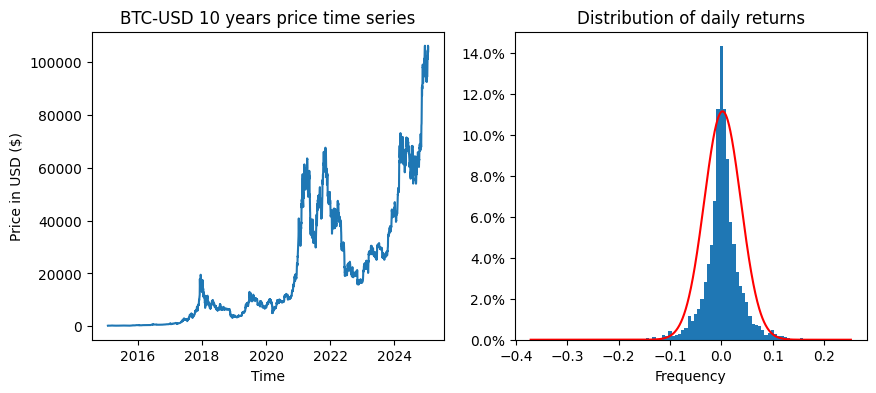

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) 

# Plot the first graph
ax1.plot(btc_close.index, btc_close.values)
ax1.set_title("BTC-USD 10 years price time series")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price in USD ($)")

# Plot the second graph
len_btc_ret = len(btc_returns_10y)
weights = np.ones(len_btc_ret)/len_btc_ret*100

ax2.hist(btc_returns_10y, bins = 100, weights = weights )
ax2.set_title("Distribution of daily returns")
ax2.set_xlabel("Frequency")
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=100)) 

"""
We overlap a gaussian distribution over the second graph to visually see how the distribution of returns
compares to a Gaussian.
"""
mu, std = norm.fit(btc_returns_10y)
x_axis_values = np.linspace(min(btc_returns_10y), max(btc_returns_10y), 1000)

pdf = norm.pdf(x_axis_values, mu, std)

ax2.plot(x_axis_values, pdf, "r-", label = "Gaussian Fit")

# Show the plot
plt.show()

In [ ]:
# Let's also perform the Jarque-Bera test to check if returns are normally distributed

jb_stats, p_value = scipy.stats.jarque_bera(btc_returns_10y)

print(f"Jarque-Bera statistic: {jb_stats}")
print(f"p-value: {p_value}")

Jarque-Bera statistic: 8768.100215295137
p-value: 0.0


From Jarque-Bera's test there seems to be sufficient evidence that returns are not normally distributed.
To get a deeper insight, let's look at the skewnees and at the kurtosis of the data.

In [ ]:
# Calculate skewness
skewness_value = scipy.stats.skew(btc_returns_10y)

# Calculate kurtosis (Fisher's definition)
kurtosis_value = scipy.stats.kurtosis(btc_returns_10y) 

print(f"Skewness: {skewness_value}")
print(f"Kurtosis: {kurtosis_value}")

Skewness: -0.0902725425922938
Kurtosis: 7.587708338817068


While the distribution seems to be centered, like the Gaussian distribution, it's evident that the tails are fatter than the normal distribution.

### Downside Analysis: Drawdown, Semideviation, VaR, CVar

In [ ]:
# We defined a welath index with a starting capital of 1000 euros
wealth_index_btc = 1000*(1+btc_returns_10y).cumprod()
previous_peaks_btc = wealth_index_btc.cummax()

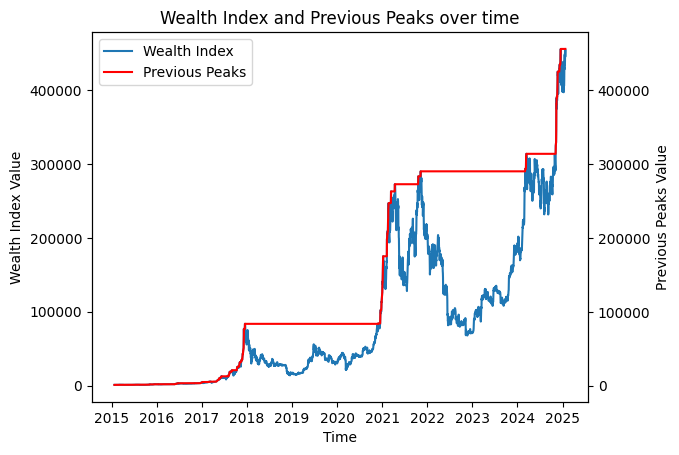

In [ ]:
fig, ax = plt.subplots()

# First of all, we create a plot with a secondary y-axis
ax.plot(wealth_index_btc, label="Wealth Index") 
ax2 = ax.twinx() 
ax2.plot(previous_peaks_btc, color="r", label="Previous Peaks") 

# We set the labels for our plot
ax.set_xlabel("Time")
ax.set_ylabel("Wealth Index Value")
ax2.set_ylabel("Previous Peaks Value")
plt.title("Wealth Index and Previous Peaks over time")

# We unite the two legends into one
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left') 

plt.show()

<Axes: xlabel='Date'>

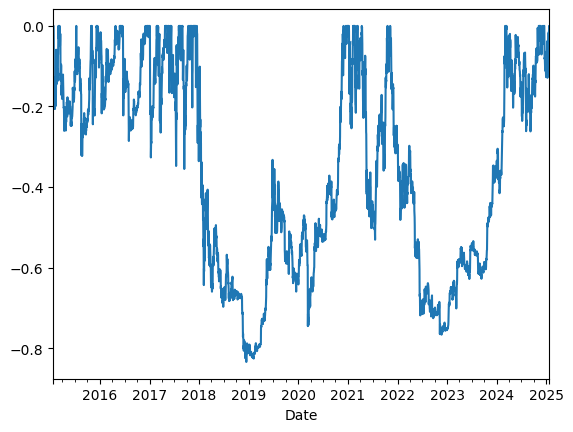

In [ ]:
# We plot the drawdowns for the wealth index over time
drawdown_btc = (wealth_index_btc - previous_peaks_btc)/previous_peaks_btc
drawdown_btc.plot()

In [ ]:
# Let's identify the maximum drawdown, and let's index when it happened

print(f"The maximum drawdown was: {-round(drawdown_btc.min(),2)}, which happened on {drawdown_btc.idxmin().strftime('%Y-%m-%d')}")

The maximum drawdown was: 0.83, which happened on 2018-12-15


In [ ]:
# Now, let's calculate the semideviation of Bitcoin's returns by using a Boolean mask

print("Bitcoin's semideviation (for daily returns) is:", round(np.std(btc_returns_10y[btc_returns_10y<0],ddof=0),2))

Bitcoin's semideviation (for daily returns) is: 0.03


In [ ]:
# Let's identify the daily VaR using the Historical Simulation Method

# We define the confidence level
alpha = 0.05

# We calculate the Historical VaR (daily frequency)
historical_var = np.quantile(btc_returns_10y.sort_values(), q= alpha)

# Let's assume a portfolio value of 1000 USD all invested in BTC-USD to estimate the VaR in monetary terms
portfolio_value = 1000

# We calculate the VaR in monetary terms
var_monetary_hist = portfolio_value * historical_var 

print("The daily VaR in monetary terms, based on historical values is:", -round(var_monetary_hist,2))


The daily VaR in monetary terms, based on historical values is: 54.42


In [ ]:
# Now, let's try a different approach: let's calculate the VaR with bootstrap

# Confidence Level
alpha = 0.05
# Wealth/Portfolio Value
portfolio_value = 1000

num_boostraps = 10000

var_estimates = np.zeros(num_boostraps)

for i in range(num_boostraps):
    # Resample with replacement
    bootstrap_sample = np.random.choice(btc_returns_10y, size = round(len(btc_returns_10y)/2), replace= True)
    var_estimates[i]=np.quantile(bootstrap_sample, alpha)

var_monetary = portfolio_value*var_estimates

print(f"Mean Bootstrap VaR: {-np.mean(var_monetary):.2f}") 
print(f"VaR at {(1-alpha)*100}% confidence level: {-np.quantile(var_monetary, (1-alpha)):.2f}") 

Mean Bootstrap VaR: 54.40
VaR at 95.0% confidence level: 49.95


In [ ]:
# Now, let's calculate the CVar based on the VaR

beyond_var_mask = btc_returns_10y*1000 <= var_monetary_hist
print("The CVaR in wealth terms is:", -round(btc_returns_10y[beyond_var_mask].mean()*1000,2))

The CVaR in wealth terms is: 83.18


# Part 2: Comparative Analysis (Monthly Data)

In [ ]:
class Analyzer:
    """
    We write this class containing functions to analyze our data.

    It takes as the input the time series of returns of an asset and allows
    us to compute different kinds of statistics.
    """

    def __init__(self, returns):
        self.returns = returns
    
    def moments(self):
        mean = np.mean(self.returns)
        stdev = np.std(self.returns)
        skew = scipy.stats.skew(self.returns)
        kurtosis = scipy.stats.kurtosis(self.returns)

        moments_dict = {"Mean": mean, "Standard Deviation": stdev, "Skewness":skew, "Kurtosis":kurtosis}

        return moments_dict
    
    def isnormal(self, alpha = 0.05):
        jb_stats, p_value = scipy.stats.jarque_bera(self.returns)

        if p_value < alpha:
            return 0
        else:
            return 1
    
    def risk_stats(self, alpha = 0.05, wealth = 1000):
        wealth_index = wealth*(1+self.returns).cumprod()
        previous_peaks = wealth_index.cummax()
        
        drawdown = (wealth_index - previous_peaks)/previous_peaks
        max_drawdown = -round(drawdown.min(),2)
        max_drawdown_date = drawdown.idxmin().strftime('%Y-%m-%d')

        semideviation = round(np.std(self.returns[self.returns<0]),2)

        historical_var = wealth*np.quantile(self.returns.sort_values(), q = alpha)

        beyond_var_mask = self.returns*wealth <= historical_var
        cvar = self.returns[beyond_var_mask].mean()*wealth
        
        risk_stats_dict = {"Max Drawdown": max_drawdown,
                           "Max Drawdown Date": max_drawdown_date,
                           "Semideviation": semideviation,
                           "Historical VaR": historical_var,
                           "CVaR": cvar}
        
        return risk_stats_dict  
    
    def annualized_vol(self, periods_per_year):
        return np.std(self.returns)*(periods_per_year**0.05)
    
    def annualized_rets(self, periods_per_year, rf_rate = 0):
        rf_per_period = ((1+rf_rate)**(1/periods_per_year))-1
        excess_returns = self.returns-rf_per_period
        compounded_growth = (1+excess_returns).prod()
        
        n_periods = self.returns.shape[0]
        
        return (compounded_growth**(periods_per_year/n_periods))-1
    
    def sharpe_ratio(self, riskfree_rate, periods):       
        ann_excess_ret = self.annualized_rets(periods_per_year= periods, rf_rate= riskfree_rate)
        ann_vol = self.annualized_vol(periods)
        
        return ann_excess_ret/ann_vol

In [ ]:
%%capture
ticker_btc = yf.Ticker("BTC-USD")
ticker_doge = yf.Ticker("DOGE-USD")
ticker_eth = yf.Ticker("ETH-USD")
tickers_stocks = yf.Tickers("AAPL MSFT AMZN GOOG TSLA NVDA BRK-B JPM JNJ PG NXPI HII MKTX DOC STM KO PEP WMT")

btc_hist = ticker_btc.history("8y").resample("M").last()

doge_hist = ticker_doge.history("8y").resample("M").last()

eth_hist = ticker_eth.history("8y").resample("M").last()

stocks_hist = tickers_stocks.history("8y").resample("M").last()
stocks_hist = stocks_hist.filter(regex="Close")
stocks_hist.columns = ["AAPL", "AMZN", "BRK-B", "GOOG", "JNJ", "JPM", "MSFT", "NVDA", "PG", "TSLA", "NXPI", "HII", "MKTX", "DOC", "STM", "KO", "PEP", "WMT"]
stocks_hist.index = stocks_hist.index.tz_localize('UTC')

In [ ]:
assets_dict = {}

assets_dict["BTC"] = btc_hist["Close"]
assets_dict["DOGE"] = doge_hist["Close"]
assets_dict["ETH"] = eth_hist["Close"]

for i in stocks_hist.columns:
    assets_dict[i] = stocks_hist[i]

In [ ]:
def get_comparative_stats(assets_dictionary):
    data = {}

    for j in assets_dict.keys():
        asset = Analyzer(assets_dictionary[j].pct_change().dropna())

        stats_dict = {
            "Mean": asset.moments()["Mean"],
            "Standard Deviation": asset.moments()["Standard Deviation"],
            "Skewness": asset.moments()["Skewness"],
            "Kurtosis": asset.moments()["Kurtosis"],
            "Normality": asset.isnormal(),
            "Max Drawdown": asset.risk_stats()["Max Drawdown"],
            "Max Drawdown Date": asset.risk_stats()["Max Drawdown Date"],
            "Semideviation": asset.risk_stats()["Semideviation"],
            "Historical VaR": asset.risk_stats()["Historical VaR"],
            "CVaR": asset.risk_stats()["CVaR"],
            "Annualized Volatility": asset.annualized_vol(12),
            "Annualized Returns": asset.annualized_rets(12),
            "Sharpe Ratio": asset.sharpe_ratio(periods= 12, riskfree_rate = 0.03)
        }

        data[j] = stats_dict

    return pd.DataFrame(data)

In [ ]:
get_comparative_stats(assets_dict)

,BTC,DOGE,ETH,AAPL,AMZN,BRK-B,GOOG,JNJ,JPM,MSFT,...,PG,TSLA,NXPI,HII,MKTX,DOC,STM,KO,PEP,WMT
Mean,0.073783,0.221761,0.060628,0.025273,0.022145,0.012158,0.003038,0.019414,0.005442,0.006155,...,0.00795,0.008001,0.022922,0.052217,0.014025,0.007212,0.009958,0.013796,0.050571,0.018115
Standard Deviation,0.228412,1.037466,0.281745,0.082672,0.088351,0.053291,0.074524,0.06934,0.080044,0.047621,...,0.047418,0.104299,0.057818,0.139609,0.097932,0.044688,0.048306,0.112678,0.192216,0.054258
Skewness,0.510319,4.830529,0.540179,-0.080825,0.192979,-0.145537,-0.305402,-0.264394,-0.61698,-0.036396,...,-0.800371,0.433509,0.011867,-0.101025,0.023555,0.069628,0.004079,0.436654,0.867816,-0.424879
Kurtosis,-0.06252,25.114925,-0.130909,-0.564698,0.987421,-0.32833,0.030139,-0.174515,1.235518,0.0311,...,1.410514,0.890582,-0.217222,0.01808,-0.018376,-0.257203,-0.347261,0.038397,1.028851,0.750722
Normality,1,0,1,1,1,1,1,1,0,1,...,0,0,1,1,1,1,1,1,0,1
Max Drawdown,0.76,0.82,0.9,0.3,0.52,0.24,0.54,0.4,0.45,0.16,...,0.24,0.64,0.31,0.63,0.41,0.18,0.21,0.53,0.68,0.22
Max Drawdown Date,2019-01-31,2022-08-31,2019-01-31,2018-12-31,2022-12-31,2022-09-30,2023-10-31,2022-12-31,2020-09-30,2024-04-30,...,2020-03-31,2024-05-31,2022-10-31,2022-09-30,2018-12-31,2025-01-31,2022-09-30,2024-12-31,2022-12-31,2018-05-31
Semideviation,0.1,0.12,0.12,0.04,0.05,0.03,0.05,0.04,0.06,0.03,...,0.04,0.06,0.03,0.08,0.06,0.03,0.03,0.06,0.08,0.04
Historical VaR,-257.955076,-346.391038,-332.93118,-115.200854,-109.303843,-69.552288,-114.096858,-98.514275,-119.646465,-70.705864,...,-84.453211,-147.323628,-69.200118,-189.861739,-124.063776,-71.561044,-78.960812,-156.924044,-209.883222,-59.872186
CVaR,-340.533989,-412.20102,-430.722157,-133.071708,-159.484022,-100.949521,-153.626206,-130.748382,-180.996912,-90.467225,...,-111.20813,-196.037174,-88.627296,-248.075045,-182.769736,-82.635952,-86.913931,-195.915289,-255.532191,-102.862842


### Efficient Frontier

In [ ]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, mean_returns):
    return np.sum(mean_returns * weights)

def efficient_return(mean_returns, cov_matrix, target_return):
    num_assets = len(mean_returns)
    args = (cov_matrix)
    def portfolio_return_constraint(weights):
        return portfolio_return(weights, mean_returns) - target_return
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': portfolio_return_constraint}
    )
    bounds = tuple((0, 1) for i in range(num_assets))
    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def minimize_volatility(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
    bounds = tuple((0, 1) for j in range(num_assets)) 
    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [ ]:
expected_returns = comparative_stats.iloc[11]

assets_df = pd.DataFrame(assets_dict)
assets_df = assets_df.pct_change().dropna()
cov_matrix = assets_df.cov()

In [ ]:
min_vol_weights = minimize_volatility(expected_returns, cov_matrix)['x']
min_vol_port_return = portfolio_return(min_vol_weights, expected_returns)
min_vol_port_std = portfolio_volatility(min_vol_weights, cov_matrix)

target_returns = np.linspace(min_vol_port_return, max(expected_returns), 30)

In [ ]:
efficient_frontier = [efficient_return(expected_returns, cov_matrix, target_return)['x'] 
                     for target_return in target_returns]

efficient_frontier_returns = [portfolio_return(w, expected_returns) for w in efficient_frontier]
efficient_frontier_volatility = [portfolio_volatility(w, cov_matrix) 
                                 for w in efficient_frontier]

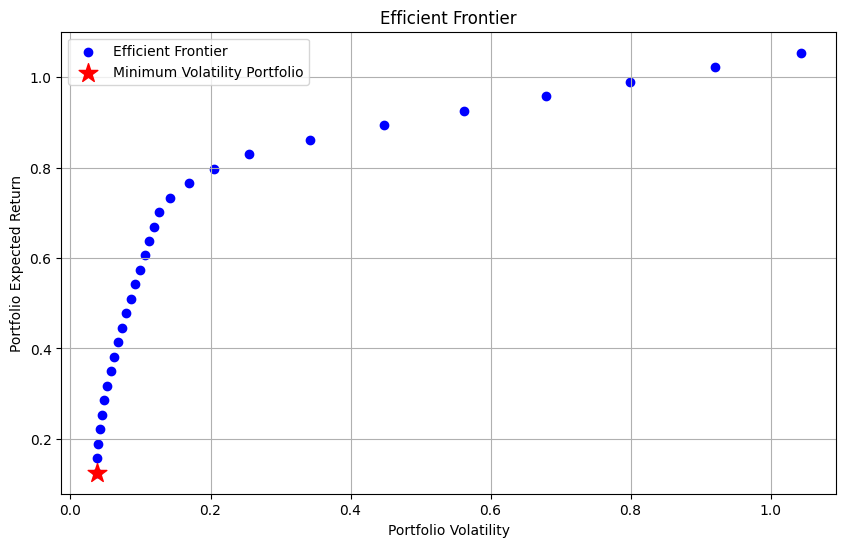

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(efficient_frontier_volatility, efficient_frontier_returns, marker='o', color='blue', label='Efficient Frontier')
plt.scatter(min_vol_port_std, min_vol_port_return, color='red', marker='*', s=200, label='Minimum Volatility Portfolio')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f"The volatility and the returns of the minimimum volatility portfolio are the following: \n Volatility: {round(min_vol_port_std,2)} \n Returns: {round(min_vol_port_return,2)}")

The volatility and the returns of the minimimum volatility portfolio are the following: 
 Volatility: 0.04 
 Returns: 0.12


### Time and volatility comparison between BTC and other Tickers

In [ ]:
# Function that plot a gaussian fit comparison of prices_btc and prices_asset 
def plot_return_distributions(prices_btc, prices_asset, asset_name, freq_label, ax):

    btc_returns = np.diff(np.log(prices_btc))
    btc_mu, btc_std = norm.fit(btc_returns)
    x_btc = np.linspace(-0.3, 0.3, 100)
    pdf_btc = norm.pdf(x_btc, btc_mu, btc_std)

    asset_returns = np.diff(np.log(prices_asset)) 
    asset_mu, asset_std = norm.fit(asset_returns)
    x_asset = np.linspace(-0.3, 0.3, 100)
    pdf_asset = norm.pdf(x_asset, asset_mu, asset_std)

    ax.plot(x_btc, pdf_btc, 'r-', label='Bitcoin Gaussian Fit')
    ax.plot(x_asset, pdf_asset, 'g-', label=f"{asset_name} Gaussian Fit")
    ax.set_title(f"{freq_label} Return Distributions")
    ax.set_xlabel("Return")
    ax.set_ylabel("Density")
    ax.set_xlim(-0.3, 0.3)
    ax.legend()

def plot_log_time_series(prices_btc, prices_asset, asset_name, ax):
        # Time series on log scale
    ax.plot(np.linspace(0, 10, len(prices_btc)), prices_btc/ prices_btc[0], label="Bitcoin")
    ax.plot(np.linspace(0, 10, len(prices_asset)), prices_asset / prices_asset[0], label=asset_name)
    ax.set_title(f"Time series (Log Scale): Bitcoin vs {asset_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price Relative to Start")
    ax.set_yscale("log")
    ax.legend()

def compare_with_btc(btc_prices, asset_prices, asset_name):

    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    plot_log_time_series(btc_prices, asset_prices, asset_name, axs[0])

    plot_return_distributions(btc_prices, asset_prices, asset_name, "Annual", axs[1])

    btc_monthly_prices = btc_prices[::30] 
    asset_monthly_prices = asset_prices[::30]
    plot_return_distributions(btc_monthly_prices, asset_monthly_prices, asset_name, "Monthly", axs[2])

    plt.tight_layout()
    plt.show()

In [ ]:
btc = yf.Ticker("BTC-USD")
btc_hist = btc.history(period="10y")
btc_prices = btc_hist["Close"].values

def fetch(asset_ticker, period="10y"):
    asset = yf.Ticker(asset_ticker)
    asset_hist = asset.history(period=period)
    
    asset_prices = asset_hist["Close"]
    return asset_prices

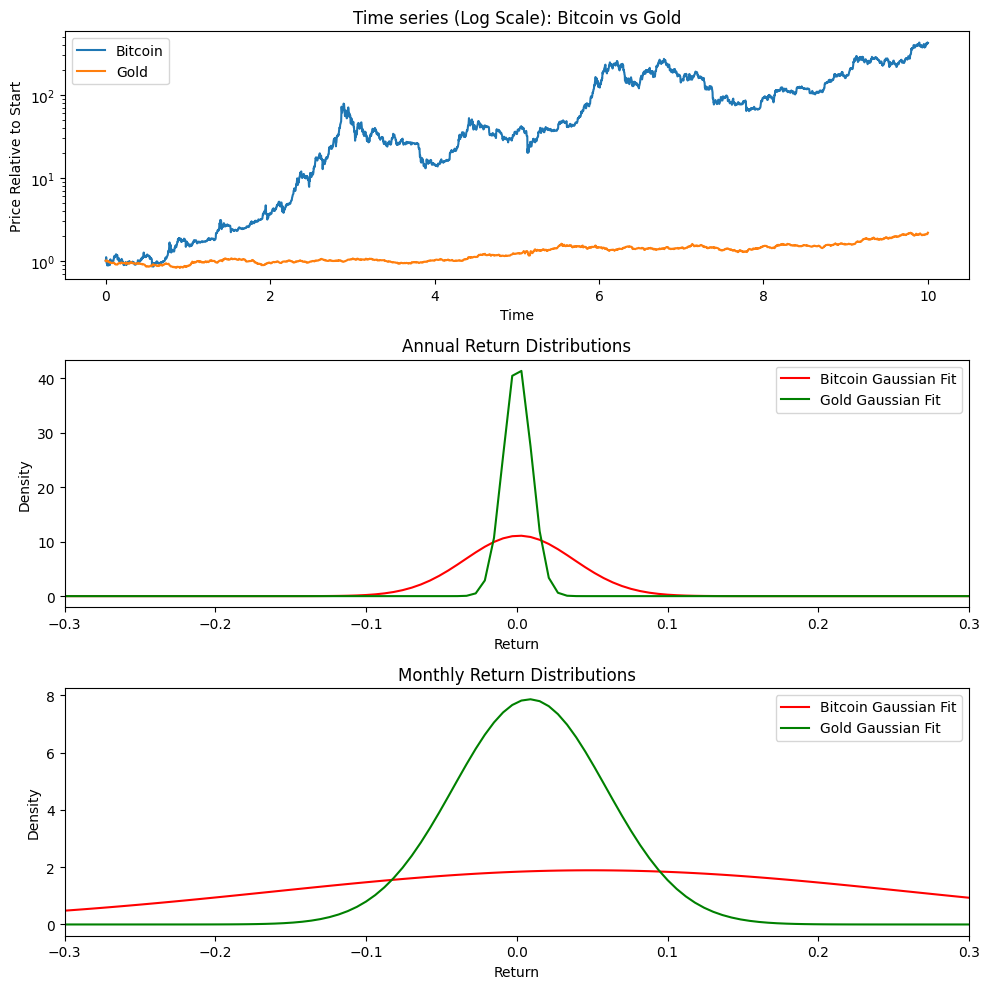

In [ ]:
compare_with_btc(btc_prices=btc_prices, asset_prices= fetch("GC=F"), asset_name="Gold")

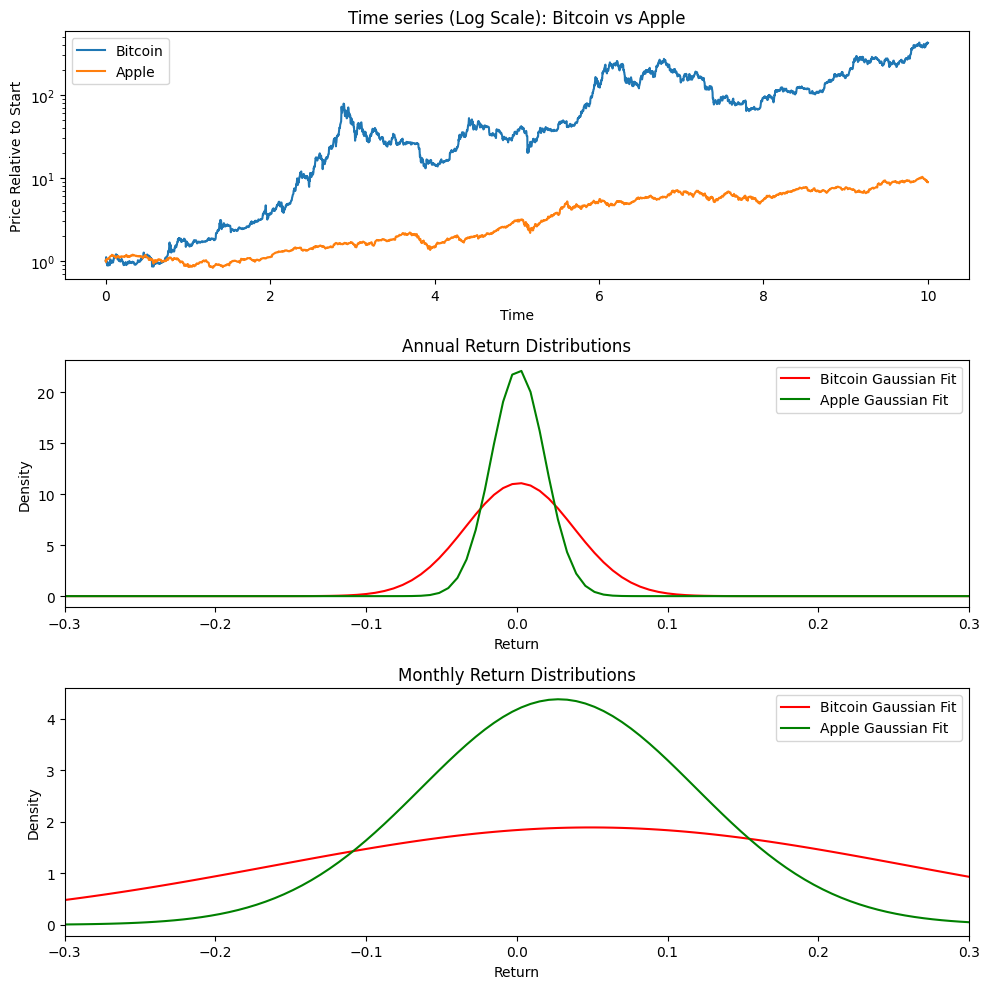

In [ ]:
compare_with_btc(btc_prices=btc_prices, asset_prices= fetch("AAPL"), asset_name="Apple")

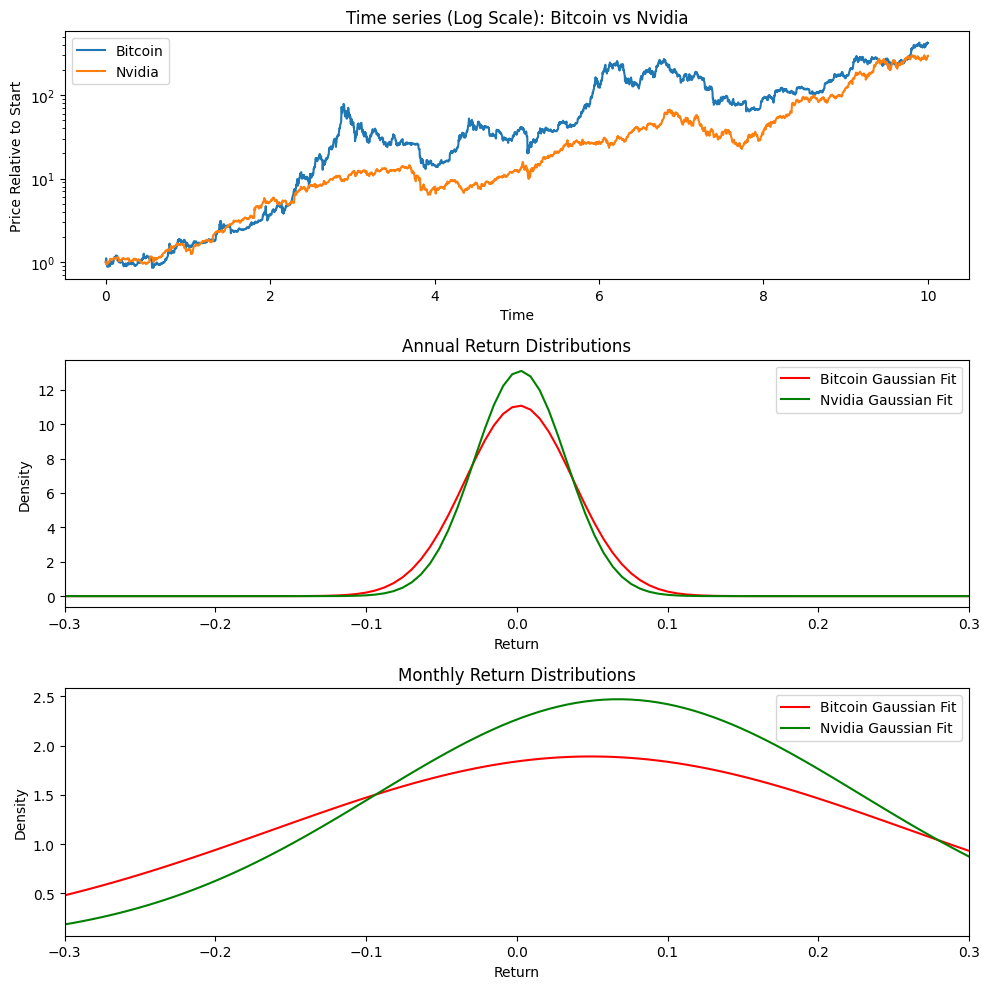

In [ ]:
compare_with_btc(btc_prices=btc_prices, asset_prices= fetch("NVDA"), asset_name="Nvidia")

# Investment Strategy with CPPI

In [ ]:
risky_r = assets_df["2018":]

safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r[:]=0.03/12

start = 1000
floor = 0.8

In [ ]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3 #multiplier
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    
    #update the account value
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    
    #save the values so I can look at the history and plot it
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value 
    

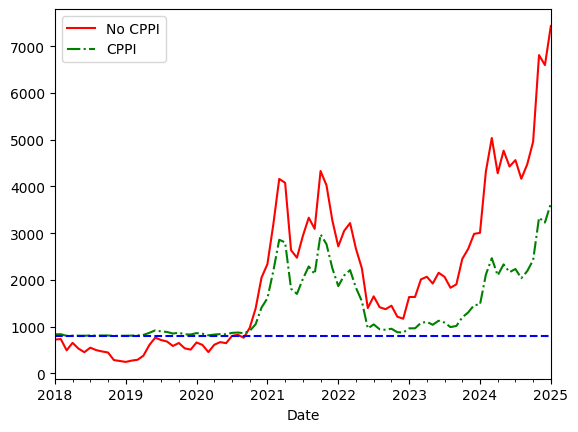

In [ ]:
risky_wealth = start*(1+risky_r).cumprod()
risky_wealth["BTC"].plot(color = "red", legend = True, label = "No CPPI")
ax = account_history["BTC"].plot(color = "green", legend = True, label = "CPPI", style = "-.")
ax.axhline(y = floor_value, color = "blue", linestyle = "--")

<Axes: xlabel='Date'>

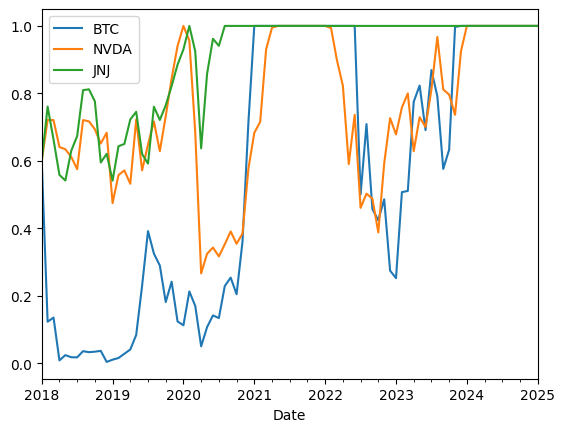

In [ ]:
risky_w_history[["BTC", "NVDA", "JNJ"]].plot()

In [ ]:
get_comparative_stats(account_history)

,BTC,DOGE,ETH,AAPL,AMZN,BRK-B,GOOG,JNJ,JPM,MSFT,...,PG,TSLA,NXPI,HII,MKTX,DOC,STM,KO,PEP,WMT
Mean,0.026636,0.126259,-0.003822,0.021438,0.017838,0.009177,0.001227,0.015796,-0.00115,0.001887,...,0.00487,0.004459,0.020745,0.041878,0.000818,0.004508,0.009928,0.000733,0.041271,0.013457
Standard Deviation,0.135651,0.684311,0.043479,0.080093,0.089272,0.047682,0.055769,0.067537,0.043694,0.038598,...,0.044717,0.101205,0.059361,0.128622,0.051239,0.03949,0.04668,0.07969,0.178865,0.049906
Skewness,0.499877,5.735062,-5.550917,-0.0254,0.143227,-0.150627,-1.015901,-0.251774,-1.558116,-0.200085,...,-0.876269,0.491777,0.03301,0.083911,-0.380073,0.180605,0.121565,0.137416,1.020726,-0.245464
Kurtosis,2.268111,37.622012,32.577781,-0.440816,0.895194,-0.213931,3.369654,-0.070457,5.956801,-0.398281,...,1.419277,1.609755,-0.288658,0.332417,0.29625,-0.21414,-0.122588,0.91869,1.911348,0.964664
Normality,0,0,0,1,1,1,0,1,0,1,...,0,0,1,1,1,1,1,1,0,1
Max Drawdown,0.71,0.82,0.3,0.26,0.52,0.24,0.42,0.4,0.28,0.17,...,0.23,0.65,0.31,0.63,0.32,0.18,0.21,0.46,0.68,0.2
Max Drawdown Date,2022-12-31,2022-08-31,2018-03-31,2022-12-31,2022-12-31,2022-09-30,2023-10-31,2022-12-31,2024-10-31,2024-04-30,...,2020-03-31,2024-04-30,2022-10-31,2022-09-30,2022-10-31,2025-01-31,2022-09-30,2024-12-31,2022-12-31,2022-06-30
Semideviation,0.09,0.11,0.1,0.04,0.05,0.03,0.04,0.04,0.04,0.02,...,0.04,0.06,0.03,0.08,0.03,0.02,0.02,0.05,0.08,0.03
Historical VaR,-167.159966,-249.180166,-23.147897,-102.432646,-110.940529,-63.457388,-85.503625,-99.978022,-60.61823,-68.628063,...,-81.962872,-159.384127,-73.528183,-168.742575,-73.637517,-56.293101,-71.761704,-119.844723,-196.536167,-58.871291
CVaR,-251.933952,-316.314843,-131.531065,-128.335088,-159.484022,-84.163297,-133.944339,-128.724392,-116.693594,-76.24724,...,-106.487256,-196.037174,-88.627296,-224.503603,-108.252018,-66.790389,-83.363082,-169.236993,-246.897394,-93.303947
